## What's this TensorFlow business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, TensorFlow (or PyTorch, if you switch over to that notebook)

#### What is it?
TensorFlow is a system for executing computational graphs over Tensor objects, with native support for performing backpropogation for its Variables. In it, we work with Tensors which are n-dimensional arrays analogous to the numpy ndarray.

#### Why?

* Our code will now run on GPUs! Much faster training. Writing your own modules to run on GPUs is beyond the scope of this class, unfortunately.
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

## How will I learn TensorFlow?

TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

Otherwise, this notebook will walk you through much of what you need to do to train models in TensorFlow. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

## Load Datasets


In [70]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline
print tf.VERSION

1.2.0-rc0


In [71]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

('Train data shape: ', (49000, 32, 32, 3))
('Train labels shape: ', (49000,))
('Validation data shape: ', (1000, 32, 32, 3))
('Validation labels shape: ', (1000,))
('Test data shape: ', (10000, 32, 32, 3))
('Test labels shape: ', (10000,))


## Example Model

### Some useful utilities

. Remember that our image data is initially N x H x W x C, where:
* N is the number of datapoints
* H is the height of each image in pixels
* W is the height of each image in pixels
* C is the number of channels (usually 3: R, G, B)

This is the right way to represent the data when we are doing something like a 2D convolution, which needs spatial understanding of where the pixels are relative to each other. When we input image data into fully connected affine layers, however, we want each data example to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data.

### The example model itself

The first step to training your own model is defining its architecture.

Here's an example of a convolutional neural network defined in TensorFlow -- try to understand what each line is doing, remembering that each layer is composed upon the previous layer. We haven't trained anything yet - that'll come next - for now, we want you to understand how everything gets set up. 

In that example, you see 2D convolutional layers (Conv2d), ReLU activations, and fully-connected layers (Linear). You also see the Hinge loss function, and the Adam optimizer being used. 

Make sure you understand why the parameters of the Linear layer are 5408 and 10.

### TensorFlow Details
In TensorFlow, much like in our previous notebooks, we'll first specifically initialize our variables, and then our network model.

In [158]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[5408, 10]) #13*13*32=5408
    b1 = tf.get_variable("b1", shape=[10])

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1,[-1,5408])
    y_out = tf.matmul(h1_flat,W1) + b1
    return y_out

y_out = simple_model(X,y)
# define our loss
total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)
# define our optimizer
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

TensorFlow supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization

### Training the model on one epoch
While we have defined a graph of operations above, in order to execute TensorFlow Graphs, by feeding them input data and computing the results, we first need to create a `tf.Session` object. A session encapsulates the control and state of the TensorFlow runtime. For more information, see the TensorFlow [Getting started](https://www.tensorflow.org/get_started/get_started) guide.

Optionally we can also specify a device context such as `/cpu:0` or `/gpu:0`. For documentation on this behavior see [this TensorFlow guide](https://www.tensorflow.org/tutorials/using_gpu)

You should see a validation loss of around 0.4 to 0.6 and an accuracy of 0.30 to 0.35 below

Training
Iteration 0: with minibatch training loss = 8.18 and accuracy of 0.094
Iteration 100: with minibatch training loss = 1.01 and accuracy of 0.25
Iteration 200: with minibatch training loss = 0.798 and accuracy of 0.28
Iteration 300: with minibatch training loss = 0.647 and accuracy of 0.39
Iteration 400: with minibatch training loss = 0.545 and accuracy of 0.3
Iteration 500: with minibatch training loss = 0.456 and accuracy of 0.39
Iteration 600: with minibatch training loss = 0.476 and accuracy of 0.27
Iteration 700: with minibatch training loss = 0.424 and accuracy of 0.38
Epoch 1, Overall loss = 0.747 and accuracy of 0.304


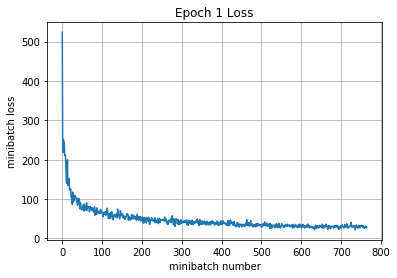

Validation
Epoch 1, Overall loss = 0.426 and accuracy of 0.329


In [159]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)*1.0/actual_batch_size))#my python version is 2.7
            iter_cnt += 1
        total_correct = 1.0*correct/Xd.shape[0] #change to float
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

## Training a specific model

In this section, we're going to specify a model for you to construct. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the TensorFlow documentation and configuring your own model. 

Using the code provided above as guidance, and using the following TensorFlow documentation, specify a model with the following architecture:

* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs



In [8]:
from keras.models import Sequential  
from keras.layers import Conv2D,MaxPooling2D,UpSampling2D,BatchNormalization,Reshape,Permute,Activation  
from keras.utils.np_utils import to_categorical  
from keras.preprocessing.image import img_to_array  
from keras.callbacks import ModelCheckpoint  

Using TensorFlow backend.


....

In [98]:
# clear old variables
tf.reset_default_graph()

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def batch_norm(x, is_training, eps=1e-05, decay=0.995, name=None):
    with tf.variable_scope(name, default_name='BatchNorm2d'):
        x_shape = x.get_shape()
        params_shape = x_shape[-1:]
        beta = tf.get_variable('beta', params_shape,
                                   initializer=tf.zeros_initializer)
        gamma = tf.get_variable('gamma', params_shape,
                                    initializer=tf.ones_initializer)
        moving_mean = tf.get_variable('mean', params_shape,
                                      initializer=tf.zeros_initializer,
                                      trainable=False)
        moving_variance = tf.get_variable('variance', params_shape,
                                          initializer=tf.ones_initializer,
                                          trainable=False)
        if is_training is not None:
            mean, variance = tf.nn.moments(x, list(range(len(x_shape) - 1)))
            update_moving_mean = tf.assign(moving_mean, moving_mean * decay + mean * (1 - decay))
            update_moving_variance = tf.assign(moving_variance, moving_variance * decay + variance * (1 - decay))
            with tf.control_dependencies([update_moving_mean, update_moving_variance]):
                return tf.nn.batch_normalization(x, mean, variance, beta, gamma, eps)
        else:
            return tf.nn.batch_normalization(x, moving_mean, moving_variance, beta, gamma, eps)
# define model
def complex_model(X,y,is_training):
    # hypreparameters
    stride = 1
    kernel_size = 7
    filters_num = 32
    max_pooling_size = 2
    max_pooling_stride = 2
    hidden_units = 1000
    num_classes = 10
    
    N, H, W, C = X.shape
    H_ = (((H - kernel_size)/stride + 1) - max_pooling_size)/max_pooling_stride + 1
    W_ = (((W - kernel_size)/stride + 1) - max_pooling_size)/max_pooling_stride + 1
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[kernel_size, kernel_size, C, filters_num])
    bconv1 = tf.get_variable("bconv1", shape=[filters_num])
    W1 = tf.get_variable("W1", shape=[H_*W_*filters_num, hidden_units])
    b1 = tf.get_variable("b1", shape=[hidden_units])
    W2 = tf.get_variable("W2", shape=[hidden_units, num_classes])
    b2 = tf.get_variable("b2", shape=[num_classes])

    # define our graph (Conv - Relu - bn - max pooling - affine - Relu - out)
    #Conv layer
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,stride,stride,1], padding='VALID') + bconv1 #N*26*26*32
    #Relu layer 1
    h1 = tf.nn.relu(a1)
    #bn layer 
    h1_bn = batch_norm(h1, is_training)
    #max pooling layer
    h1_bn_maxpooling = tf.nn.max_pool(h1_bn, 
                                      [1,max_pooling_size,max_pooling_size,1], 
                                      [1,max_pooling_stride,max_pooling_stride,1], 
                                      padding='VALID')#N*13*13*32
#     print h1_bn_maxpooling.get_shape()
#     dim = H_*W_*filters_num
#     print dim
    h1_flat = tf.reshape(h1_bn_maxpooling,[-1,5408])
    #affine layer
    h2 = tf.matmul(h1_flat, W1) + b1
    #Relu layer 2
    h2_relu = tf.nn.relu(h2)
    #out layer
    y_out = tf.matmul(h2_relu, W2) + b2
    return y_out
    pass

y_out = complex_model(X,y,is_training)

In [99]:
print y_out.get_shape()

(?, 10)


To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 64 x 10, since our batches have size 64 and the output of the final affine layer should be 10, corresponding to our 10 classes):

In [100]:
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
x = np.random.randn(64, 32, 32,3)
with tf.Session() as sess:
#     with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0"
    with tf.device("/gpu:0"):
        tf.global_variables_initializer().run()

        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 10])))

1000 loops, best of 3: 1.93 ms per loop
(64, 10)
True


You should see the following from the run above 

`(64, 10)`

`True`

### GPU!

Now, we're going to try and start the model under the GPU device, the rest of the code stays unchanged and all our variables and operations will be computed using accelerated code paths. However, if there is no GPU, we get a Python exception and have to rebuild our graph. On a dual-core CPU, you might see around 50-80ms/batch running the above, while the Google Cloud GPUs (run below) should be around 2-5ms/batch.

In [101]:
try:
    with tf.Session() as sess:
        with tf.device("/gpu:0") as dev: #"/cpu:0" or "/gpu:0"
            tf.global_variables_initializer().run()

            ans = sess.run(y_out,feed_dict={X:x,is_training:True})
            %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud if you want GPU acceleration")    
    # rebuild the graph
    # trying to start a GPU throws an exception 
    # and also trashes the original graph
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    is_training = tf.placeholder(tf.bool)
    y_out = complex_model(X,y,is_training)

1000 loops, best of 3: 1.92 ms per loop


NOTE:The slowest run took 4.85 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 1.93 ms per loop

You should observe that even a simple forward pass like this is significantly faster on the GPU. So for the rest of the assignment (and when you go train your models in assignment 3 and your project!), you should use GPU devices. However, with TensorFlow, the default device is a GPU if one is available, and a CPU otherwise, so we can skip the device specification from now on.

### Train the model.

Now that you've seen how to define a model and do a single forward pass of some data through it, let's  walk through how you'd actually train one whole epoch over your training data (using the complex_model you created provided above).

Make sure you understand how each TensorFlow function used below corresponds to what you implemented in your custom neural network implementation.

First, set up an **RMSprop optimizer** (using a 1e-3 learning rate) and a **cross-entropy loss** function. See the TensorFlow documentation for more information
* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers

In [115]:
# Inputs
#     y_out: is what your model computes
#     y: is your TensorFlow variable with label information
# Outputs
#    mean_loss: a TensorFlow variable (scalar) with numerical loss
#    optimizer: a TensorFlow optimizer
# This should be ~3 lines of code!
mean_loss = None
optimizer = None
pass
scores = tf.nn.softmax(y_out)
loss = -tf.reduce_sum(tf.one_hot(y,10) * tf.log(scores))
mean_loss = loss / tf.cast(tf.size(y), tf.float32)
optimizer = tf.train.RMSPropOptimizer(1e-3)

In [116]:
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

### Train the model
Below we'll create a session and train the model over one epoch. You should see a loss of 1.4 to 2.0 and an accuracy of 0.4 to 0.5. There will be some variation due to random seeds and differences in initialization

In [117]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step)

Training
Iteration 0: with minibatch training loss = 3.5 and accuracy of 0.11
Iteration 100: with minibatch training loss = 2.06 and accuracy of 0.38
Iteration 200: with minibatch training loss = 1.37 and accuracy of 0.47
Iteration 300: with minibatch training loss = 1.89 and accuracy of 0.36
Iteration 400: with minibatch training loss = 1.47 and accuracy of 0.48
Iteration 500: with minibatch training loss = 1.39 and accuracy of 0.53
Iteration 600: with minibatch training loss = 1.35 and accuracy of 0.55
Iteration 700: with minibatch training loss = 1.3 and accuracy of 0.52
Epoch 1, Overall loss = 1.68 and accuracy of 0.449


(1.6831208800491022, 0.4486734693877551)

### Check the accuracy of the model.

Let's see the train and test code in action -- feel free to use these methods when evaluating the models you develop below. You should see a loss of 1.3 to 2.0 with an accuracy of 0.45 to 0.55.

In [118]:
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Validation
Epoch 1, Overall loss = 1.23 and accuracy of 0.533


(1.2347875137329101, 0.533)

## Train a _great_ model on CIFAR-10!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves ** >= 70% accuracy on the validation set** of CIFAR-10. You can use the `run_model` function from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Use TensorFlow Scope**: Use TensorFlow scope and/or [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) to make it easier to write deeper networks. See [this tutorial](https://www.tensorflow.org/tutorials/layers) for how to use `tf.layers`. 
- **Use Learning Rate Decay**: [As the notes point out](http://cs231n.github.io/neural-networks-3/#anneal), decaying the learning rate might help the model converge. Feel free to decay every epoch, when loss doesn't change over an entire epoch, or any other heuristic you find appropriate. See the [Tensorflow documentation](https://www.tensorflow.org/versions/master/api_guides/python/train#Decaying_the_learning_rate) for learning rate decay.
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use [Dropout as in the TensorFlow MNIST tutorial](https://www.tensorflow.org/get_started/mnist/pros)

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and we'll save the test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at **>= 70% accuracy on the validation set**. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training and validation set accuracies for your final trained network.

Have fun and happy training!

In [153]:
# Feel free to play with this cell

#conv1 - bn1 - conv2 - conv3 - bn2 - maxpooling1 
#-> conv4 - maxpooling2 
#-> conv5 - maxpooling3 
#-> bn3 - conv6 - maxpooling4
#-Global Average Pooling - affine1 - bn4 - dropout - out
def my_model(X,y,is_training):
    #input shape X=[N,H,W,C] [batch_size, 32,32,3]
    #Conv layer #1
    conv1 = tf.layers.conv2d(
        inputs = X,             #[?,32,32,3]
        filters = 32,
        kernel_size = [5,5],
        strides = (1,1),
        padding = "SAME",
        activation = tf.nn.relu,
        name="conv1")
    #bn layer #1
    bn1 = batch_norm(conv1,     #[?,32,32,32]
                     is_training,
                     eps=1e-05,
                     decay=0.995,
                     name='batch_normalization1')

    #Conv layer #2
    conv2 = tf.layers.conv2d(
        inputs = bn1,       #[?,32,32,32]
        filters = 64,
        kernel_size = [3,3],
        strides = (1,1),
        padding = "SAME",
        activation = tf.nn.relu,
        name="conv2")
    #Conv layer #3
    conv3 = tf.layers.conv2d(
        inputs = conv2,             #[?,32,32,64]
        filters = 128,
        kernel_size = [3,3],
        strides = (1,1),
        padding = "SAME",
        activation = tf.nn.relu,
        name="conv3")
    #bn layer #2
    bn2 = batch_norm(conv3,     #[?,32,32,128]
                     is_training,
                     eps=1e-05,
                     decay=0.995,
                     name='batch_normalization2')
    #max pooling layer #1
    maxpooling1 = tf.layers.max_pooling2d(bn2,      #[?,32,32,128]
                                    pool_size = [2,2],
                                    strides = [2,2],
                                    padding = 'SAME',
                                    name = 'pool_layer1')
    #Conv layer #4
    conv4 = tf.layers.conv2d(
        inputs = maxpooling1,             #[?,16,16,128]
        filters = 256,
        kernel_size = [3,3],
        strides = (1,1),
        padding = "SAME",
        activation = tf.nn.relu,
        name="conv4")
    #max pooling layer #2
    maxpooling2 = tf.layers.max_pooling2d(conv4,      #[?,16,16,256]
                                    pool_size = [2,2],
                                    strides = [2,2],
                                    padding = 'SAME',
                                    name = 'pool_layer2')
    #Conv layer #5
    conv5 = tf.layers.conv2d(
        inputs = maxpooling1,             #[?,16,16,128]
        filters = 512,
        kernel_size = [5,5],
        strides = (1,1),
        padding = "SAME",
        activation = tf.nn.relu,
        name="conv5")
    #max pooling layer #3
    maxpooling3 = tf.layers.max_pooling2d(conv5,      #[?,16,16,512]
                                    pool_size = [2,2],
                                    strides = [2,2],
                                    padding = 'SAME',
                                    name = 'pool_layer3')
    #bn layer #3
    bn3 = batch_norm(maxpooling3,     #[?,8,8,512]
                     is_training,
                     eps=1e-05,
                     decay=0.995,
                     name='batch_normalization3')
    #Conv layer #6
    conv6 = tf.layers.conv2d(
        inputs = bn3,             #[?,8,8,512]
        filters = 1024,
        kernel_size = [3,3],
        strides = (1,1),
        padding = "SAME",
        activation = tf.nn.relu,
        name="conv6")
    #max pooling layer #4
    maxpooling4 = tf.layers.max_pooling2d(conv6,      #[?,8,8,1024]
                                    pool_size = [2,2],
                                    strides = [2,2],
                                    padding = 'SAME',
                                    name = 'pool_layer4')
    #Global Average Pooling
    glob_aver_pooling = tf.layers.average_pooling2d(maxpooling4, #[?,4,4,1024]
                                                    pool_size = [4, 4], 
                                                    strides = [4,4], 
                                                    padding = 'SAME',
                                                    name = 'global_average_pooling1')
    h1_input = tf.reshape(glob_aver_pooling, [-1, 1024])
    #affine layer#1
    h1 = tf.layers.dense(h1_input,
                             units = 2048,
                             activation = tf.nn.relu,
                             name = 'hidden_layer1')
    #dropout
    dropout = tf.layers.dropout(inputs=h1, 
                                rate=0.5, 
                                training=is_training)
    #bn layer #4
    bn4 = batch_norm(dropout,     #[?,2048]
                     is_training,
                     eps=1e-05,
                     decay=0.995,
                     name='batch_normalization4')
    #out layer
    y_out = tf.layers.dense(bn4,
                             units = 10,
                             activation = tf.nn.relu,
                             name = 'output_layer')
    print conv1.get_shape()
    print conv2.get_shape()
    print conv3.get_shape()
    print conv4.get_shape()
    print conv5.get_shape()
    print conv6.get_shape()
    print maxpooling4.get_shape()
    print glob_aver_pooling.get_shape()
    print h1.get_shape()
    return y_out
    pass

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X,y,is_training)
print y_out.get_shape()
mean_loss = None
optimizer = None

scores = tf.nn.softmax(y_out)
loss = -tf.reduce_sum(tf.one_hot(y,10) * tf.log(scores))
mean_loss = loss / tf.cast(tf.size(y), tf.float32)
#learning rate decay
initial_learning_rate = 1e-3
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(initial_learning_rate,
                                           global_step=global_step,
                                           decay_steps=8,decay_rate=0.9)
optimizer = tf.train.RMSPropOptimizer(learning_rate)
pass

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

(?, 32, 32, 32)
(?, 32, 32, 64)
(?, 32, 32, 128)
(?, 16, 16, 256)
(?, 16, 16, 512)
(?, 8, 8, 1024)
(?, 4, 4, 1024)
(?, 1, 1, 1024)
(?, 2048)
(?, 10)


Training
Iteration 0: with minibatch training loss = 2.53 and accuracy of 0.12
Iteration 100: with minibatch training loss = 2.25 and accuracy of 0.3
Iteration 200: with minibatch training loss = 1.96 and accuracy of 0.3
Iteration 300: with minibatch training loss = 1.82 and accuracy of 0.33
Iteration 400: with minibatch training loss = 1.94 and accuracy of 0.22
Iteration 500: with minibatch training loss = 1.66 and accuracy of 0.44
Iteration 600: with minibatch training loss = 1.49 and accuracy of 0.47
Iteration 700: with minibatch training loss = 1.42 and accuracy of 0.45
Epoch 1, Overall loss = 1.77 and accuracy of 0.376


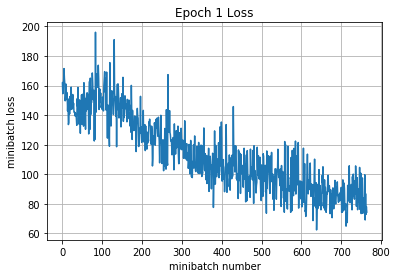

Iteration 800: with minibatch training loss = 1.22 and accuracy of 0.62
Iteration 900: with minibatch training loss = 0.964 and accuracy of 0.64
Iteration 1000: with minibatch training loss = 1.12 and accuracy of 0.62
Iteration 1100: with minibatch training loss = 1.2 and accuracy of 0.55
Iteration 1200: with minibatch training loss = 0.962 and accuracy of 0.58
Iteration 1300: with minibatch training loss = 1.31 and accuracy of 0.56
Iteration 1400: with minibatch training loss = 0.846 and accuracy of 0.64
Iteration 1500: with minibatch training loss = 0.679 and accuracy of 0.77
Epoch 2, Overall loss = 1.06 and accuracy of 0.625


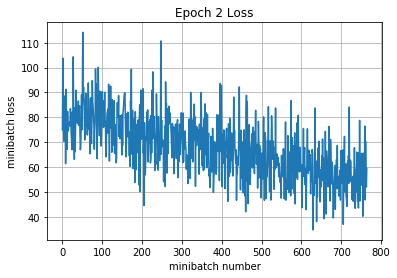

Iteration 1600: with minibatch training loss = 0.909 and accuracy of 0.64
Iteration 1700: with minibatch training loss = 0.846 and accuracy of 0.67
Iteration 1800: with minibatch training loss = 0.793 and accuracy of 0.75
Iteration 1900: with minibatch training loss = 0.717 and accuracy of 0.73
Iteration 2000: with minibatch training loss = 0.673 and accuracy of 0.83
Iteration 2100: with minibatch training loss = 0.631 and accuracy of 0.81
Iteration 2200: with minibatch training loss = 0.785 and accuracy of 0.72
Epoch 3, Overall loss = 0.773 and accuracy of 0.73


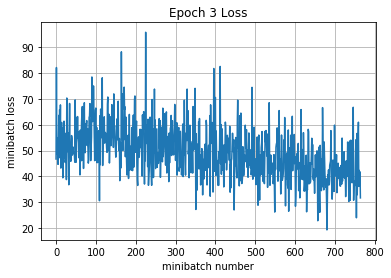

Iteration 2300: with minibatch training loss = 0.538 and accuracy of 0.83
Iteration 2400: with minibatch training loss = 0.596 and accuracy of 0.8
Iteration 2500: with minibatch training loss = 0.389 and accuracy of 0.91
Iteration 2600: with minibatch training loss = 0.648 and accuracy of 0.75
Iteration 2700: with minibatch training loss = 0.601 and accuracy of 0.78
Iteration 2800: with minibatch training loss = 0.736 and accuracy of 0.67
Iteration 2900: with minibatch training loss = 0.594 and accuracy of 0.81
Iteration 3000: with minibatch training loss = 0.467 and accuracy of 0.78
Epoch 4, Overall loss = 0.595 and accuracy of 0.795


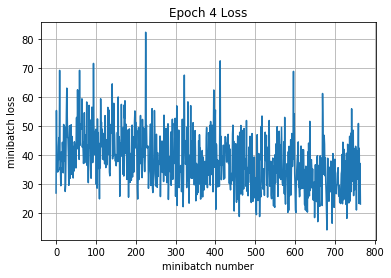

Iteration 3100: with minibatch training loss = 0.453 and accuracy of 0.81
Iteration 3200: with minibatch training loss = 0.604 and accuracy of 0.78
Iteration 3300: with minibatch training loss = 0.446 and accuracy of 0.89
Iteration 3400: with minibatch training loss = 0.415 and accuracy of 0.83
Iteration 3500: with minibatch training loss = 0.472 and accuracy of 0.83
Iteration 3600: with minibatch training loss = 0.294 and accuracy of 0.92
Iteration 3700: with minibatch training loss = 0.402 and accuracy of 0.83
Iteration 3800: with minibatch training loss = 0.593 and accuracy of 0.86
Epoch 5, Overall loss = 0.434 and accuracy of 0.852


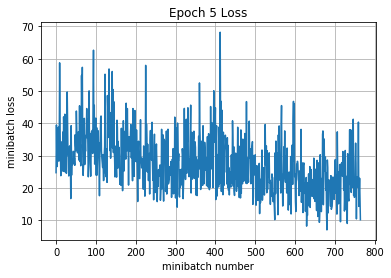

Iteration 3900: with minibatch training loss = 0.409 and accuracy of 0.84
Iteration 4000: with minibatch training loss = 0.352 and accuracy of 0.89
Iteration 4100: with minibatch training loss = 0.219 and accuracy of 0.92
Iteration 4200: with minibatch training loss = 0.406 and accuracy of 0.88
Iteration 4300: with minibatch training loss = 0.36 and accuracy of 0.88
Iteration 4400: with minibatch training loss = 0.244 and accuracy of 0.91
Iteration 4500: with minibatch training loss = 0.116 and accuracy of 0.95
Epoch 6, Overall loss = 0.298 and accuracy of 0.898


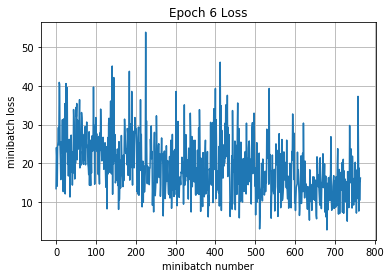

Iteration 4600: with minibatch training loss = 0.196 and accuracy of 0.94
Iteration 4700: with minibatch training loss = 0.408 and accuracy of 0.91
Iteration 4800: with minibatch training loss = 0.222 and accuracy of 0.97
Iteration 4900: with minibatch training loss = 0.274 and accuracy of 0.92
Iteration 5000: with minibatch training loss = 0.0555 and accuracy of 0.98
Iteration 5100: with minibatch training loss = 0.17 and accuracy of 0.97
Iteration 5200: with minibatch training loss = 0.0391 and accuracy of 0.98
Iteration 5300: with minibatch training loss = 0.239 and accuracy of 0.94
Epoch 7, Overall loss = 0.197 and accuracy of 0.933


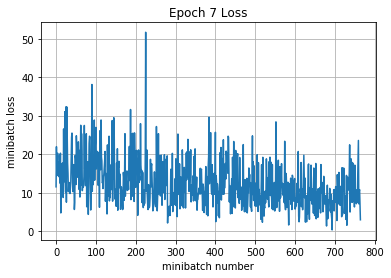

Iteration 5400: with minibatch training loss = 0.192 and accuracy of 0.94
Iteration 5500: with minibatch training loss = 0.27 and accuracy of 0.92
Iteration 5600: with minibatch training loss = 0.0584 and accuracy of 0.98
Iteration 5700: with minibatch training loss = 0.156 and accuracy of 0.94
Iteration 5800: with minibatch training loss = 0.227 and accuracy of 0.88
Iteration 5900: with minibatch training loss = 0.0696 and accuracy of 0.97
Iteration 6000: with minibatch training loss = 0.0712 and accuracy of 0.98
Iteration 6100: with minibatch training loss = 0.0586 and accuracy of 0.97
Epoch 8, Overall loss = 0.142 and accuracy of 0.952


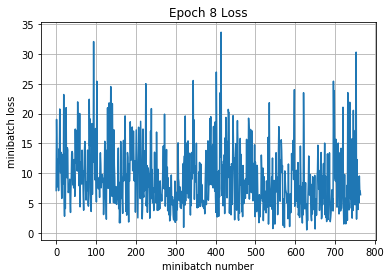

Iteration 6200: with minibatch training loss = 0.333 and accuracy of 0.89
Iteration 6300: with minibatch training loss = 0.12 and accuracy of 0.95
Iteration 6400: with minibatch training loss = 0.0725 and accuracy of 0.95
Iteration 6500: with minibatch training loss = 0.0772 and accuracy of 0.98
Iteration 6600: with minibatch training loss = 0.212 and accuracy of 0.92
Iteration 6700: with minibatch training loss = 0.0886 and accuracy of 0.97
Iteration 6800: with minibatch training loss = 0.00575 and accuracy of 1
Epoch 9, Overall loss = 0.11 and accuracy of 0.963


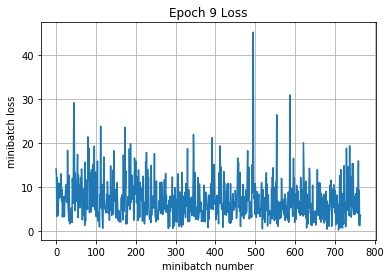

Iteration 6900: with minibatch training loss = 0.0492 and accuracy of 0.97
Iteration 7000: with minibatch training loss = 0.143 and accuracy of 0.95
Iteration 7100: with minibatch training loss = 0.0685 and accuracy of 0.97
Iteration 7200: with minibatch training loss = 0.041 and accuracy of 0.98
Iteration 7300: with minibatch training loss = 0.0326 and accuracy of 0.98
Iteration 7400: with minibatch training loss = 0.0708 and accuracy of 0.95
Iteration 7500: with minibatch training loss = 0.196 and accuracy of 0.92
Iteration 7600: with minibatch training loss = 0.151 and accuracy of 0.98
Epoch 10, Overall loss = 0.0924 and accuracy of 0.968


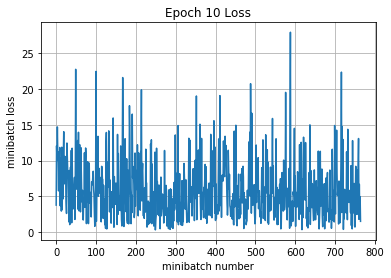

Validation
Epoch 1, Overall loss = 1.17 and accuracy of 0.789


(1.167237829208374, 0.789)

In [154]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [155]:
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Epoch 1, Overall loss = 0.141 and accuracy of 0.964
Validation
Epoch 1, Overall loss = 1.25 and accuracy of 0.796


(1.2481370582580567, 0.796)

### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network

I make a net architecture like that:
#conv1 - bn1 - conv2 - conv3 - bn2 - maxpooling1 
#-> conv4 - maxpooling2 
#-> conv5 - maxpooling3 
#-> bn3 - conv6 - maxpooling4
#-Global Average Pooling - affine1 - bn4 - out
#Since the input image resolution is small(32*32). We should use convolution kernels to extract features from these input images, there are must exist some big features and small features. So, in there, I applied different sizes of convolution kernels:(5×5) and(3×3). And, in order to extract more features, the number of filters is becoming larger and larger:number of filters 32->64->128->256->512->1024. In terms to max pooling layers, I think the original input image resolution is so small that we may loss some features, if we do max pooling after some top part convolution layers, even the extracted features are usually overlapped in the condition that stride is equal to one. 
#By 6 convolution layers and some batch normalization layers, we get 1024 features. Then applied a affine layer with 2048 units. Why expand to 2048? Personally, just guess, every image has many features, these features form a set. Assume all of the ten classes image have 1024 features(maybe less than or more than)(note:set S={si | i=1,2,...,1024}, it contains 1024 features). Each unit in 2048 units is a combination of some elements in set S, it is a subset of S. Note:S'. It's value can be represent as the sum of all elements in S’ and every elements in set S' multiply a weight(maybe a feature s is only belongs to one class, so it may has large weight when this unit contribute a lot to this class, conversely, a feature is common and it has small weight to all the classes). Note as : unit_value = sum_all(wi×si）, si in set S'. Consider the number of combination of some elements in set S is very large, it should be 1024! in very extreme condition. So, 2048 is ok.
#Maybe we can remove a or some features and observe the accuracy for one or two appointed classes. If the accuracy turn down a lot that means this feature is special for this class. If the accuracies for all class are change nothing that means this feature is useless.
#It can be useful for compress the model, because tha parameters in affine part is very large, we can decrease them by do this without changing the accuracy. Moreover, if you work in model security, you should take some measures to protect these important features, in case someone cheat the model by them.

### Test Set - Do this only once
Now that we've gotten a result that we're happy with, we test our final model on the test set. This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [156]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Test
Epoch 1, Overall loss = 1.4 and accuracy of 0.801


(1.4049109512329101, 0.8009)

## Going further with TensorFlow

The next assignment will make heavy use of TensorFlow. You might also find it useful for your projects. 


# Extra Credit Description
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.

# Add more affine layer
Assume: Do that may represent more combination of features, it will benefit to accuracy or overfitting.

In [160]:
#conv1 - bn1 - conv2 - conv3 - bn2 - maxpooling1 
#-> conv4 - maxpooling2 
#-> conv5 - maxpooling3 
#-> bn3 - conv6 - maxpooling4
#-Global Average Pooling - affine1 - bn4 - dropout affine2 - bn5 - out
def my_model(X,y,is_training):
    #input shape X=[N,H,W,C] [batch_size, 32,32,3]
    #Conv layer #1
    conv1 = tf.layers.conv2d(
        inputs = X,             #[?,32,32,3]
        filters = 32,
        kernel_size = [5,5],
        strides = (1,1),
        padding = "SAME",
        activation = tf.nn.relu,
        name="conv1")
    #bn layer #1
    bn1 = batch_norm(conv1,     #[?,32,32,32]
                     is_training,
                     eps=1e-05,
                     decay=0.995,
                     name='batch_normalization1')

    #Conv layer #2
    conv2 = tf.layers.conv2d(
        inputs = bn1,       #[?,32,32,32]
        filters = 64,
        kernel_size = [3,3],
        strides = (1,1),
        padding = "SAME",
        activation = tf.nn.relu,
        name="conv2")
    #Conv layer #3
    conv3 = tf.layers.conv2d(
        inputs = conv2,             #[?,32,32,64]
        filters = 128,
        kernel_size = [3,3],
        strides = (1,1),
        padding = "SAME",
        activation = tf.nn.relu,
        name="conv3")
    #bn layer #2
    bn2 = batch_norm(conv3,     #[?,32,32,128]
                     is_training,
                     eps=1e-05,
                     decay=0.995,
                     name='batch_normalization2')
    #max pooling layer #1
    maxpooling1 = tf.layers.max_pooling2d(bn2,      #[?,32,32,128]
                                    pool_size = [2,2],
                                    strides = [2,2],
                                    padding = 'SAME',
                                    name = 'pool_layer1')
    #Conv layer #4
    conv4 = tf.layers.conv2d(
        inputs = maxpooling1,             #[?,16,16,128]
        filters = 256,
        kernel_size = [3,3],
        strides = (1,1),
        padding = "SAME",
        activation = tf.nn.relu,
        name="conv4")
    #max pooling layer #2
    maxpooling2 = tf.layers.max_pooling2d(conv4,      #[?,16,16,256]
                                    pool_size = [2,2],
                                    strides = [2,2],
                                    padding = 'SAME',
                                    name = 'pool_layer2')
    #Conv layer #5
    conv5 = tf.layers.conv2d(
        inputs = maxpooling1,             #[?,16,16,128]
        filters = 512,
        kernel_size = [5,5],
        strides = (1,1),
        padding = "SAME",
        activation = tf.nn.relu,
        name="conv5")
    #max pooling layer #3
    maxpooling3 = tf.layers.max_pooling2d(conv5,      #[?,16,16,512]
                                    pool_size = [2,2],
                                    strides = [2,2],
                                    padding = 'SAME',
                                    name = 'pool_layer3')
    #bn layer #3
    bn3 = batch_norm(maxpooling3,     #[?,8,8,512]
                     is_training,
                     eps=1e-05,
                     decay=0.995,
                     name='batch_normalization3')
    #Conv layer #6
    conv6 = tf.layers.conv2d(
        inputs = bn3,             #[?,8,8,512]
        filters = 1024,
        kernel_size = [3,3],
        strides = (1,1),
        padding = "SAME",
        activation = tf.nn.relu,
        name="conv6")
    #max pooling layer #4
    maxpooling4 = tf.layers.max_pooling2d(conv6,      #[?,8,8,1024]
                                    pool_size = [2,2],
                                    strides = [2,2],
                                    padding = 'SAME',
                                    name = 'pool_layer4')
    #Global Average Pooling
    glob_aver_pooling = tf.layers.average_pooling2d(maxpooling4, #[?,4,4,1024]
                                                    pool_size = [4, 4], 
                                                    strides = [4,4], 
                                                    padding = 'SAME',
                                                    name = 'global_average_pooling1')
    h1_input = tf.reshape(glob_aver_pooling, [-1, 1024])
#     h1_feature_hidden = 
    #affine layer#1
    h1 = tf.layers.dense(h1_input,
                             units = 4096,
                             activation = tf.nn.relu,
                             name = 'hidden_layer1')
    #dropout
    dropout = tf.layers.dropout(inputs=h1, 
                                rate=0.5, 
                                training=is_training)
    #bn layer #4
    bn4 = batch_norm(dropout,     #[?,2048]
                     is_training,
                     eps=1e-05,
                     decay=0.995,
                     name='batch_normalization4')
    
    #affine layer #2
    h2 = tf.layers.dense(bn4,
                             units = 1024,
                             activation = tf.nn.relu,
                             name = 'hidden_layer2')
    #dropout
    dropout = tf.layers.dropout(inputs=h2, 
                                rate=0.5, 
                                training=is_training)
    #bn layer #5
    bn5 = batch_norm(dropout,     #[?,2048]
                     is_training,
                     eps=1e-05,
                     decay=0.995,
                     name='batch_normalization5')
    #out layer
    y_out = tf.layers.dense(bn5,
                             units = 10,
                             activation = tf.nn.relu,
                             name = 'output_layer')
    print conv1.get_shape()
    print conv2.get_shape()
    print conv3.get_shape()
    print conv4.get_shape()
    print conv5.get_shape()
    print conv6.get_shape()
    print maxpooling4.get_shape()
    print glob_aver_pooling.get_shape()
    print h1.get_shape()
    return y_out
    pass

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X,y,is_training)
print y_out.get_shape()
mean_loss = None
optimizer = None

scores = tf.nn.softmax(y_out)
loss = -tf.reduce_sum(tf.one_hot(y,10) * tf.log(scores))
mean_loss = loss / tf.cast(tf.size(y), tf.float32)
#learning rate decay
initial_learning_rate = 1e-3
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(initial_learning_rate,
                                           global_step=global_step,
                                           decay_steps=8,decay_rate=0.9)
optimizer = tf.train.RMSPropOptimizer(learning_rate)
pass

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

(?, 32, 32, 32)
(?, 32, 32, 64)
(?, 32, 32, 128)
(?, 16, 16, 256)
(?, 16, 16, 512)
(?, 8, 8, 1024)
(?, 4, 4, 1024)
(?, 1, 1, 1024)
(?, 4096)
(?, 10)


Training
Iteration 0: with minibatch training loss = 2.97 and accuracy of 0.031
Iteration 100: with minibatch training loss = 2.55 and accuracy of 0.27
Iteration 200: with minibatch training loss = 1.96 and accuracy of 0.28
Iteration 300: with minibatch training loss = 1.74 and accuracy of 0.3
Iteration 400: with minibatch training loss = 1.73 and accuracy of 0.38
Iteration 500: with minibatch training loss = 1.67 and accuracy of 0.44
Iteration 600: with minibatch training loss = 1.35 and accuracy of 0.5
Iteration 700: with minibatch training loss = 1.61 and accuracy of 0.39
Epoch 1, Overall loss = 1.89 and accuracy of 0.325


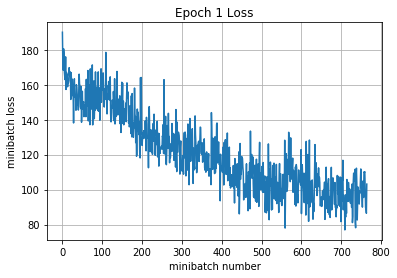

Iteration 800: with minibatch training loss = 1.3 and accuracy of 0.52
Iteration 900: with minibatch training loss = 1.44 and accuracy of 0.45
Iteration 1000: with minibatch training loss = 1.21 and accuracy of 0.45
Iteration 1100: with minibatch training loss = 1.37 and accuracy of 0.55
Iteration 1200: with minibatch training loss = 1.18 and accuracy of 0.58
Iteration 1300: with minibatch training loss = 1.18 and accuracy of 0.66
Iteration 1400: with minibatch training loss = 0.923 and accuracy of 0.64
Iteration 1500: with minibatch training loss = 0.995 and accuracy of 0.55
Epoch 2, Overall loss = 1.28 and accuracy of 0.547


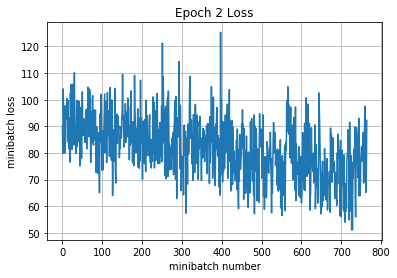

Iteration 1600: with minibatch training loss = 1.03 and accuracy of 0.64
Iteration 1700: with minibatch training loss = 1.02 and accuracy of 0.67
Iteration 1800: with minibatch training loss = 0.932 and accuracy of 0.72
Iteration 1900: with minibatch training loss = 0.96 and accuracy of 0.62
Iteration 2000: with minibatch training loss = 1.18 and accuracy of 0.64
Iteration 2100: with minibatch training loss = 1.37 and accuracy of 0.56
Iteration 2200: with minibatch training loss = 0.853 and accuracy of 0.7
Epoch 3, Overall loss = 1.03 and accuracy of 0.634


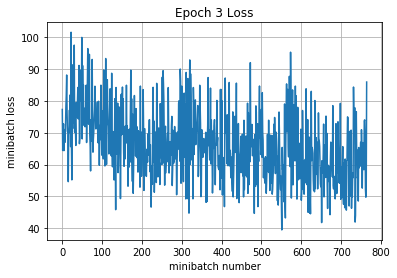

Iteration 2300: with minibatch training loss = 0.763 and accuracy of 0.67
Iteration 2400: with minibatch training loss = 1.08 and accuracy of 0.7
Iteration 2500: with minibatch training loss = 0.784 and accuracy of 0.73
Iteration 2600: with minibatch training loss = 1.02 and accuracy of 0.69
Iteration 2700: with minibatch training loss = 0.762 and accuracy of 0.73
Iteration 2800: with minibatch training loss = 0.882 and accuracy of 0.7
Iteration 2900: with minibatch training loss = 0.699 and accuracy of 0.78
Iteration 3000: with minibatch training loss = 0.538 and accuracy of 0.81
Epoch 4, Overall loss = 0.853 and accuracy of 0.703


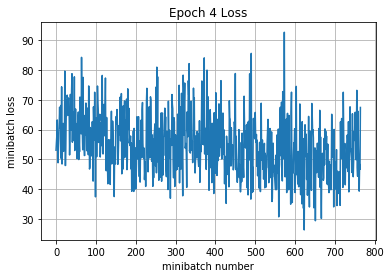

Iteration 3100: with minibatch training loss = 1.24 and accuracy of 0.66
Iteration 3200: with minibatch training loss = 0.539 and accuracy of 0.81
Iteration 3300: with minibatch training loss = 0.651 and accuracy of 0.81
Iteration 3400: with minibatch training loss = 0.674 and accuracy of 0.81
Iteration 3500: with minibatch training loss = 0.746 and accuracy of 0.72
Iteration 3600: with minibatch training loss = 0.534 and accuracy of 0.89
Iteration 3700: with minibatch training loss = 0.66 and accuracy of 0.8
Iteration 3800: with minibatch training loss = 0.889 and accuracy of 0.7
Epoch 5, Overall loss = 0.699 and accuracy of 0.758


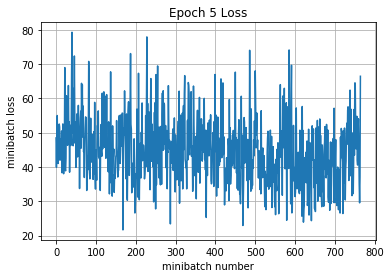

Iteration 3900: with minibatch training loss = 0.564 and accuracy of 0.78
Iteration 4000: with minibatch training loss = 0.541 and accuracy of 0.83
Iteration 4100: with minibatch training loss = 0.746 and accuracy of 0.64
Iteration 4200: with minibatch training loss = 0.472 and accuracy of 0.88
Iteration 4300: with minibatch training loss = 0.627 and accuracy of 0.78
Iteration 4400: with minibatch training loss = 0.546 and accuracy of 0.78
Iteration 4500: with minibatch training loss = 0.546 and accuracy of 0.8
Epoch 6, Overall loss = 0.563 and accuracy of 0.807


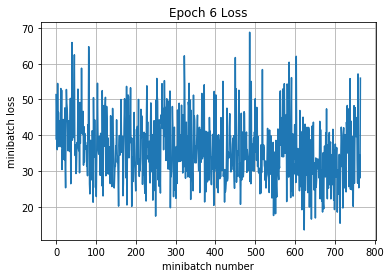

Iteration 4600: with minibatch training loss = 0.421 and accuracy of 0.84
Iteration 4700: with minibatch training loss = 0.41 and accuracy of 0.84
Iteration 4800: with minibatch training loss = 0.42 and accuracy of 0.88
Iteration 4900: with minibatch training loss = 0.29 and accuracy of 0.95
Iteration 5000: with minibatch training loss = 0.338 and accuracy of 0.86
Iteration 5100: with minibatch training loss = 0.401 and accuracy of 0.89
Iteration 5200: with minibatch training loss = 0.487 and accuracy of 0.8
Iteration 5300: with minibatch training loss = 0.277 and accuracy of 0.88
Epoch 7, Overall loss = 0.444 and accuracy of 0.849


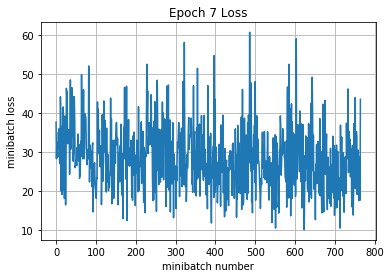

Iteration 5400: with minibatch training loss = 0.634 and accuracy of 0.84
Iteration 5500: with minibatch training loss = 0.269 and accuracy of 0.88
Iteration 5600: with minibatch training loss = 0.192 and accuracy of 0.92
Iteration 5700: with minibatch training loss = 0.602 and accuracy of 0.75
Iteration 5800: with minibatch training loss = 0.244 and accuracy of 0.89
Iteration 5900: with minibatch training loss = 0.305 and accuracy of 0.88
Iteration 6000: with minibatch training loss = 0.241 and accuracy of 0.92
Iteration 6100: with minibatch training loss = 0.211 and accuracy of 0.91
Epoch 8, Overall loss = 0.34 and accuracy of 0.886


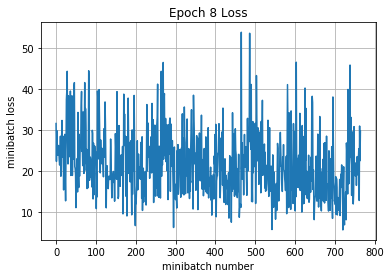

Iteration 6200: with minibatch training loss = 0.277 and accuracy of 0.92
Iteration 6300: with minibatch training loss = 0.184 and accuracy of 0.94
Iteration 6400: with minibatch training loss = 0.447 and accuracy of 0.86
Iteration 6500: with minibatch training loss = 0.174 and accuracy of 0.92
Iteration 6600: with minibatch training loss = 0.302 and accuracy of 0.92
Iteration 6700: with minibatch training loss = 0.366 and accuracy of 0.89
Iteration 6800: with minibatch training loss = 0.093 and accuracy of 0.97
Epoch 9, Overall loss = 0.245 and accuracy of 0.917


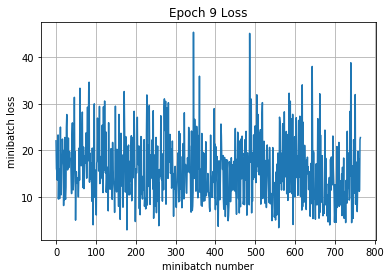

Iteration 6900: with minibatch training loss = 0.0753 and accuracy of 0.98
Iteration 7000: with minibatch training loss = 0.263 and accuracy of 0.94
Iteration 7100: with minibatch training loss = 0.137 and accuracy of 0.95
Iteration 7200: with minibatch training loss = 0.314 and accuracy of 0.92
Iteration 7300: with minibatch training loss = 0.24 and accuracy of 0.92
Iteration 7400: with minibatch training loss = 0.191 and accuracy of 0.92
Iteration 7500: with minibatch training loss = 0.0618 and accuracy of 1
Iteration 7600: with minibatch training loss = 0.214 and accuracy of 0.95
Epoch 10, Overall loss = 0.185 and accuracy of 0.938


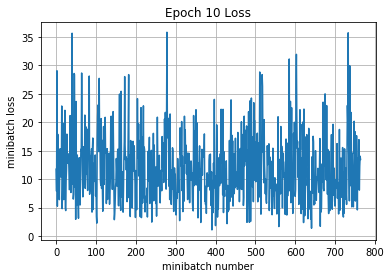

Validation
Epoch 1, Overall loss = 1.04 and accuracy of 0.785


(1.0441054115295409, 0.785)

In [161]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [162]:
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Epoch 1, Overall loss = 0.202 and accuracy of 0.946
Validation
Epoch 1, Overall loss = 1.08 and accuracy of 0.785


(1.0800455360412597, 0.785)

In [163]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Test
Epoch 1, Overall loss = 1.26 and accuracy of 0.796


(1.258196550655365, 0.7965)

# Result
It shows model with more affine layers doesn't work better in there.

# 2 Augment image
Perform zero padding, randomly crop image to original size, maybe mirror horizontally.
Reference:https://github.com/ikhlestov/vision_networks/blob/master/data_providers/cifar.py

In [170]:
def augment_image(image, pad):
    """Perform zero padding, randomly crop image to original size,
    maybe mirror horizontally"""
    init_shape = image.shape
    new_shape = [init_shape[0] + pad * 2,
                 init_shape[1] + pad * 2,
                 init_shape[2]]
    zeros_padded = np.zeros(new_shape)
    zeros_padded[pad:init_shape[0] + pad, pad:init_shape[1] + pad, :] = image
    # randomly crop to original size
    init_x = np.random.randint(0, pad * 2)
    init_y = np.random.randint(0, pad * 2)
    cropped = zeros_padded[
        init_x: init_x + init_shape[0],
        init_y: init_y + init_shape[1],
        :]
    flip = random.getrandbits(1)
    if flip:
        cropped = cropped[:, ::-1, :]
    return cropped

In [171]:
def augment_all_images(initial_images, pad):
    new_images = np.zeros(initial_images.shape)
    for i in range(initial_images.shape[0]):
        new_images[i] = augment_image(initial_images[i], pad=4)
    return new_images

In [173]:
from cs231n.data_utils import load_CIFAR10
import random

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train_orgi, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    #augment all images
    #pad = 4 is got from them
    X_train = augment_all_images(X_train_orgi, pad = 4)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

('Train data shape: ', (49000, 32, 32, 3))
('Train labels shape: ', (49000,))
('Validation data shape: ', (1000, 32, 32, 3))
('Validation labels shape: ', (1000,))
('Test data shape: ', (10000, 32, 32, 3))
('Test labels shape: ', (10000,))


In [178]:
#conv1 - bn1 - conv2 - conv3 - bn2 - maxpooling1 
#-> conv4 - maxpooling2 
#-> conv5 - maxpooling3 
#-> bn3 - conv6 - maxpooling4
#-Global Average Pooling - affine1 - bn4 - dropout affine2 - bn5 - out
def my_model(X,y,is_training):
    #input shape X=[N,H,W,C] [batch_size, 32,32,3]
    #Conv layer #1
    conv1 = tf.layers.conv2d(
        inputs = X,             #[?,32,32,3]
        filters = 32,
        kernel_size = [5,5],
        strides = (1,1),
        padding = "SAME",
        activation = tf.nn.relu,
        name="conv1")
    #bn layer #1
    bn1 = batch_norm(conv1,     #[?,32,32,32]
                     is_training,
                     eps=1e-05,
                     decay=0.995,
                     name='batch_normalization1')

    #Conv layer #2
    conv2 = tf.layers.conv2d(
        inputs = bn1,       #[?,32,32,32]
        filters = 64,
        kernel_size = [3,3],
        strides = (1,1),
        padding = "SAME",
        activation = tf.nn.relu,
        name="conv2")
    #Conv layer #3
    conv3 = tf.layers.conv2d(
        inputs = conv2,             #[?,32,32,64]
        filters = 128,
        kernel_size = [3,3],
        strides = (1,1),
        padding = "SAME",
        activation = tf.nn.relu,
        name="conv3")
    #bn layer #2
    bn2 = batch_norm(conv3,     #[?,32,32,128]
                     is_training,
                     eps=1e-05,
                     decay=0.995,
                     name='batch_normalization2')
    #max pooling layer #1
    maxpooling1 = tf.layers.max_pooling2d(bn2,      #[?,32,32,128]
                                    pool_size = [2,2],
                                    strides = [2,2],
                                    padding = 'SAME',
                                    name = 'pool_layer1')
    #Conv layer #4
    conv4 = tf.layers.conv2d(
        inputs = maxpooling1,             #[?,16,16,128]
        filters = 256,
        kernel_size = [3,3],
        strides = (1,1),
        padding = "SAME",
        activation = tf.nn.relu,
        name="conv4")
    #max pooling layer #2
    maxpooling2 = tf.layers.max_pooling2d(conv4,      #[?,16,16,256]
                                    pool_size = [2,2],
                                    strides = [2,2],
                                    padding = 'SAME',
                                    name = 'pool_layer2')
    #Conv layer #5
    conv5 = tf.layers.conv2d(
        inputs = maxpooling1,             #[?,16,16,128]
        filters = 512,
        kernel_size = [5,5],
        strides = (1,1),
        padding = "SAME",
        activation = tf.nn.relu,
        name="conv5")
    #max pooling layer #3
    maxpooling3 = tf.layers.max_pooling2d(conv5,      #[?,16,16,512]
                                    pool_size = [2,2],
                                    strides = [2,2],
                                    padding = 'SAME',
                                    name = 'pool_layer3')
    #bn layer #3
    bn3 = batch_norm(maxpooling3,     #[?,8,8,512]
                     is_training,
                     eps=1e-05,
                     decay=0.995,
                     name='batch_normalization3')
    #Conv layer #6
    conv6 = tf.layers.conv2d(
        inputs = bn3,             #[?,8,8,512]
        filters = 1024,
        kernel_size = [3,3],
        strides = (1,1),
        padding = "SAME",
        activation = tf.nn.relu,
        name="conv6")
    #max pooling layer #4
    maxpooling4 = tf.layers.max_pooling2d(conv6,      #[?,8,8,1024]
                                    pool_size = [2,2],
                                    strides = [2,2],
                                    padding = 'SAME',
                                    name = 'pool_layer4')
    #Global Average Pooling
    glob_aver_pooling = tf.layers.average_pooling2d(maxpooling4, #[?,4,4,1024]
                                                    pool_size = [4, 4], 
                                                    strides = [4,4], 
                                                    padding = 'SAME',
                                                    name = 'global_average_pooling1')
    h1_input = tf.reshape(glob_aver_pooling, [-1, 1024])
#     h1_feature_hidden = 
    #affine layer#1
    h1 = tf.layers.dense(h1_input,
                             units = 4096,
                             activation = tf.nn.relu,
                             name = 'hidden_layer1')
    #dropout
    dropout = tf.layers.dropout(inputs=h1, 
                                rate=0.5, 
                                training=is_training)
    #bn layer #4
    bn4 = batch_norm(dropout,     #[?,2048]
                     is_training,
                     eps=1e-05,
                     decay=0.995,
                     name='batch_normalization4')

    #out layer
    y_out = tf.layers.dense(bn4,
                             units = 10,
                             activation = tf.nn.relu,
                             name = 'output_layer')
    print conv1.get_shape()
    print conv2.get_shape()
    print conv3.get_shape()
    print conv4.get_shape()
    print conv5.get_shape()
    print conv6.get_shape()
    print maxpooling4.get_shape()
    print glob_aver_pooling.get_shape()
    print h1.get_shape()
    return y_out
    pass

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X,y,is_training)
print y_out.get_shape()
mean_loss = None
optimizer = None

scores = tf.nn.softmax(y_out)
loss = -tf.reduce_sum(tf.one_hot(y,10) * tf.log(scores))
mean_loss = loss / tf.cast(tf.size(y), tf.float32)
#learning rate decay
initial_learning_rate = 1e-3
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(initial_learning_rate,
                                           global_step=global_step,
                                           decay_steps=8,decay_rate=0.9)
optimizer = tf.train.RMSPropOptimizer(learning_rate)
pass

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

(?, 32, 32, 32)
(?, 32, 32, 64)
(?, 32, 32, 128)
(?, 16, 16, 256)
(?, 16, 16, 512)
(?, 8, 8, 1024)
(?, 4, 4, 1024)
(?, 1, 1, 1024)
(?, 4096)
(?, 10)


Training
Iteration 0: with minibatch training loss = 2.62 and accuracy of 0.12
Iteration 100: with minibatch training loss = 2.21 and accuracy of 0.28
Iteration 200: with minibatch training loss = 2.09 and accuracy of 0.2
Iteration 300: with minibatch training loss = 1.97 and accuracy of 0.19
Iteration 400: with minibatch training loss = 1.65 and accuracy of 0.36
Iteration 500: with minibatch training loss = 1.46 and accuracy of 0.45
Iteration 600: with minibatch training loss = 1.54 and accuracy of 0.41
Iteration 700: with minibatch training loss = 1.75 and accuracy of 0.39
Epoch 1, Overall loss = 1.89 and accuracy of 0.329


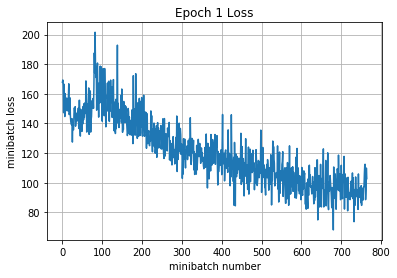

Iteration 800: with minibatch training loss = 1.33 and accuracy of 0.5
Iteration 900: with minibatch training loss = 1.2 and accuracy of 0.61
Iteration 1000: with minibatch training loss = 1.01 and accuracy of 0.61
Iteration 1100: with minibatch training loss = 1.29 and accuracy of 0.53
Iteration 1200: with minibatch training loss = 1.28 and accuracy of 0.67
Iteration 1300: with minibatch training loss = 1.25 and accuracy of 0.56
Iteration 1400: with minibatch training loss = 1.04 and accuracy of 0.67
Iteration 1500: with minibatch training loss = 1.04 and accuracy of 0.66
Epoch 2, Overall loss = 1.24 and accuracy of 0.56


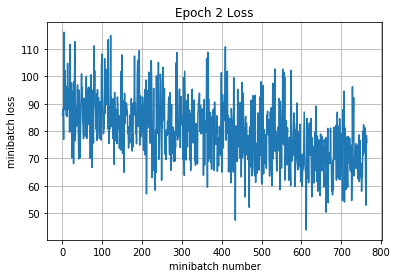

Iteration 1600: with minibatch training loss = 0.987 and accuracy of 0.69
Iteration 1700: with minibatch training loss = 1.04 and accuracy of 0.64
Iteration 1800: with minibatch training loss = 1.11 and accuracy of 0.64
Iteration 1900: with minibatch training loss = 0.735 and accuracy of 0.75
Iteration 2000: with minibatch training loss = 0.939 and accuracy of 0.64
Iteration 2100: with minibatch training loss = 0.997 and accuracy of 0.66
Iteration 2200: with minibatch training loss = 0.951 and accuracy of 0.69
Epoch 3, Overall loss = 0.968 and accuracy of 0.668


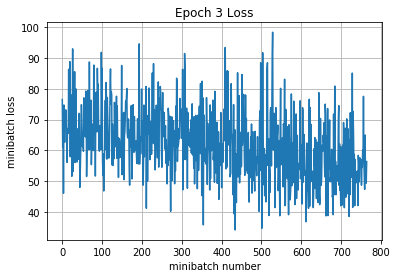

Iteration 2300: with minibatch training loss = 0.641 and accuracy of 0.77
Iteration 2400: with minibatch training loss = 0.703 and accuracy of 0.73
Iteration 2500: with minibatch training loss = 0.952 and accuracy of 0.64
Iteration 2600: with minibatch training loss = 0.927 and accuracy of 0.73
Iteration 2700: with minibatch training loss = 0.905 and accuracy of 0.73
Iteration 2800: with minibatch training loss = 0.637 and accuracy of 0.8
Iteration 2900: with minibatch training loss = 0.476 and accuracy of 0.84
Iteration 3000: with minibatch training loss = 0.71 and accuracy of 0.75
Epoch 4, Overall loss = 0.743 and accuracy of 0.75


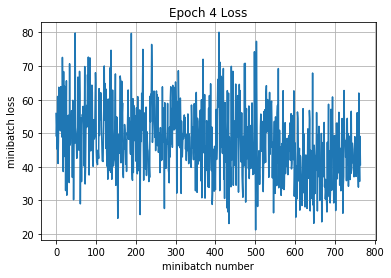

Iteration 3100: with minibatch training loss = 0.658 and accuracy of 0.8
Iteration 3200: with minibatch training loss = 0.484 and accuracy of 0.86
Iteration 3300: with minibatch training loss = 0.696 and accuracy of 0.75
Iteration 3400: with minibatch training loss = 0.855 and accuracy of 0.78
Iteration 3500: with minibatch training loss = 0.873 and accuracy of 0.7
Iteration 3600: with minibatch training loss = 0.594 and accuracy of 0.83
Iteration 3700: with minibatch training loss = 0.567 and accuracy of 0.8
Iteration 3800: with minibatch training loss = 0.372 and accuracy of 0.88
Epoch 5, Overall loss = 0.561 and accuracy of 0.81


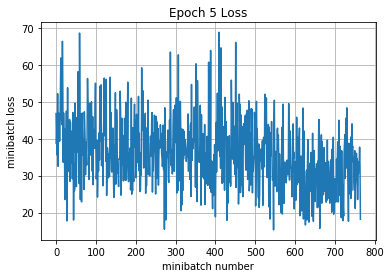

Iteration 3900: with minibatch training loss = 0.369 and accuracy of 0.89
Iteration 4000: with minibatch training loss = 0.352 and accuracy of 0.84
Iteration 4100: with minibatch training loss = 0.467 and accuracy of 0.81
Iteration 4200: with minibatch training loss = 0.471 and accuracy of 0.86
Iteration 4300: with minibatch training loss = 0.753 and accuracy of 0.78
Iteration 4400: with minibatch training loss = 0.364 and accuracy of 0.83
Iteration 4500: with minibatch training loss = 0.349 and accuracy of 0.86
Epoch 6, Overall loss = 0.406 and accuracy of 0.863


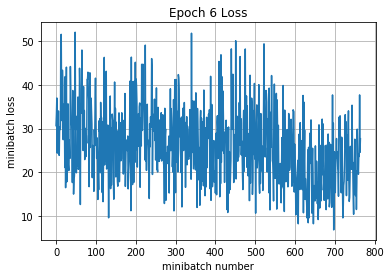

Iteration 4600: with minibatch training loss = 0.372 and accuracy of 0.84
Iteration 4700: with minibatch training loss = 0.523 and accuracy of 0.8
Iteration 4800: with minibatch training loss = 0.344 and accuracy of 0.91
Iteration 4900: with minibatch training loss = 0.372 and accuracy of 0.86
Iteration 5000: with minibatch training loss = 0.315 and accuracy of 0.92
Iteration 5100: with minibatch training loss = 0.13 and accuracy of 0.95
Iteration 5200: with minibatch training loss = 0.24 and accuracy of 0.94
Iteration 5300: with minibatch training loss = 0.441 and accuracy of 0.86
Epoch 7, Overall loss = 0.276 and accuracy of 0.906


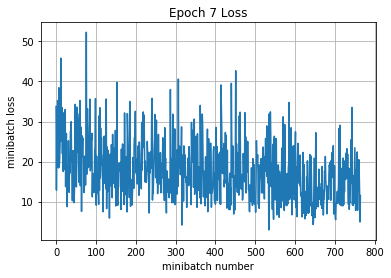

Iteration 5400: with minibatch training loss = 0.153 and accuracy of 0.92
Iteration 5500: with minibatch training loss = 0.0746 and accuracy of 0.97
Iteration 5600: with minibatch training loss = 0.2 and accuracy of 0.94
Iteration 5700: with minibatch training loss = 0.116 and accuracy of 0.95
Iteration 5800: with minibatch training loss = 0.25 and accuracy of 0.91
Iteration 5900: with minibatch training loss = 0.0722 and accuracy of 0.97
Iteration 6000: with minibatch training loss = 0.212 and accuracy of 0.92
Iteration 6100: with minibatch training loss = 0.0434 and accuracy of 0.98
Epoch 8, Overall loss = 0.196 and accuracy of 0.935


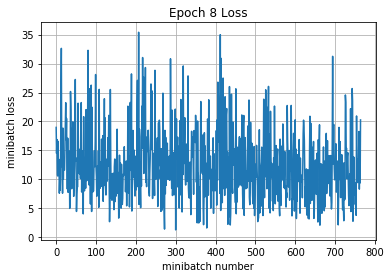

Iteration 6200: with minibatch training loss = 0.261 and accuracy of 0.92
Iteration 6300: with minibatch training loss = 0.128 and accuracy of 0.95
Iteration 6400: with minibatch training loss = 0.121 and accuracy of 0.95
Iteration 6500: with minibatch training loss = 0.262 and accuracy of 0.92
Iteration 6600: with minibatch training loss = 0.0564 and accuracy of 0.98
Iteration 6700: with minibatch training loss = 0.16 and accuracy of 0.95
Iteration 6800: with minibatch training loss = 0.0462 and accuracy of 0.98
Epoch 9, Overall loss = 0.158 and accuracy of 0.948


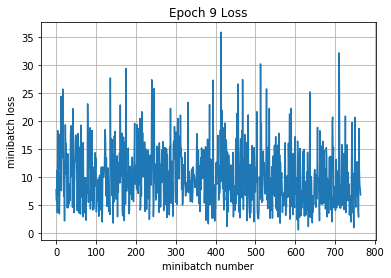

Iteration 6900: with minibatch training loss = 0.247 and accuracy of 0.92
Iteration 7000: with minibatch training loss = 0.0732 and accuracy of 0.97
Iteration 7100: with minibatch training loss = 0.157 and accuracy of 0.95
Iteration 7200: with minibatch training loss = 0.03 and accuracy of 0.98
Iteration 7300: with minibatch training loss = 0.1 and accuracy of 0.98
Iteration 7400: with minibatch training loss = 0.201 and accuracy of 0.94
Iteration 7500: with minibatch training loss = 0.179 and accuracy of 0.97
Iteration 7600: with minibatch training loss = 0.0361 and accuracy of 1
Epoch 10, Overall loss = 0.132 and accuracy of 0.956


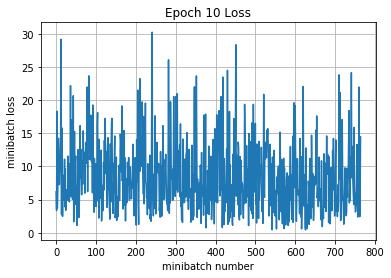

Validation
Epoch 1, Overall loss = 1.63 and accuracy of 0.739


(1.629185806274414, 0.739)

In [179]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [180]:
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Epoch 1, Overall loss = 0.208 and accuracy of 0.949
Validation
Epoch 1, Overall loss = 1.74 and accuracy of 0.738


(1.7401656494140625, 0.738)

In [181]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Test
Epoch 1, Overall loss = nan and accuracy of 0.777


(nan, 0.7769)

loss = nan????

# It doesn't work